## import necessary packages

In [1]:
## basics
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

## data preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

## models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
## ensemble
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
# import catboost as cb
from mlxtend.classifier import StackingClassifier

## model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

## model evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## Read the data

In [2]:
df = pd.read_csv('/Volumes/Backup Plus/Documents/Data Science/Projects/fannieMae_project/processed_data/Fannie_loans.csv')

In [3]:
df["Default"].mean()

0.016885376097890665

In [4]:
df.head()

,Unnamed: 0,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrLTV,OrCLTV,NumBorrowers,DTIRat,CreditScore,NumUnits,...,FTHomeBuyer,LoanPurpose,PropertyType,OccType,PropertyState,ProductType,RelocationMortgage,Zip,first_payment_year,loan_year
0,0,8.500,82000,360,97.0,100.0,2.0,59.0,670.0,1,...,Y,P,CO,P,CA,FRM,N,927,2000,2000
1,1,7.875,165000,360,97.0,100.0,2.0,38.0,669.0,1,...,Y,P,CO,P,CA,FRM,N,926,2000,2000
2,2,8.375,137000,360,97.0,100.0,2.0,31.0,747.0,1,...,Y,P,SF,P,CA,FRM,N,919,2000,1999
3,3,7.625,113000,180,85.0,88.0,2.0,18.0,621.0,1,...,N,R,SF,P,RI,FRM,N,29,1999,1999
4,4,8.125,209000,360,97.0,100.0,2.0,64.0,672.0,1,...,Y,P,SF,P,CA,FRM,N,926,2000,1999


In [5]:
df_new=df.loc[df['loan_year']==2007]
df_new=df_new.drop(["Unnamed: 0"], axis=1)
df_new["MortInsType"]=df_new["MortInsType"].astype("category")
df_new["Zip"]=df_new["Zip"].astype("category")
df_new["first_payment_year"]=df_new["first_payment_year"].astype("category")
df_new["loan_year"]=df_new["loan_year"].astype("category")

In [6]:
df_new["Default"].mean()

0.12629413038769763

In [7]:
df_new.shape

(92340, 25)

In [8]:
df_new = pd.get_dummies(df_new, drop_first=True)
df_new.shape

(92340, 982)

In [9]:
# Get column names first
names = df_new.columns
# Create the Scaler object
scaler = StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df_new)
scaled_df = pd.DataFrame(df_new, columns=names)

In [10]:
y = scaled_df['Default'].values
X = scaled_df.drop(['Default'], axis=1).values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

### KNN model 

In [12]:
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)
knn_pred=knn.predict(X_test)

### decision tree model

In [13]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred=dt.predict(X_test)

### regular logistic model

In [14]:
lr = LogisticRegression(random_state=1, class_weight="balanced")
lr.fit(X_train, y_train)
lr_pred=lr.predict(X_test)

### accuracy scores

In [15]:
a_score_knn=accuracy_score(y_test, knn_pred)
a_score_dt=accuracy_score(y_test, dt_pred)
a_score_lr=accuracy_score(y_test, lr_pred)

# Print the accuracy scores
print(a_score_knn)
print(a_score_dt)
print(a_score_lr)

0.8553173056097033
0.8180203595408274
0.6409356725146199


### F1 Score:
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

$$ F1 = 2 * \frac{precision * recall}{precision + recall} $$

In [16]:
from sklearn.metrics import f1_score

score_knn = f1_score(y_test, knn_pred)
score_dt = f1_score(y_test, dt_pred)
score_lr = f1_score(y_test, lr_pred)

# Print the f1 scores
print(score_knn)
print(score_dt)
print(score_lr)

0.07015590200445433
0.24155984834807723
0.32626188734455014


## heterogeneous ensemble 
* wisedom of the crowd
* use fine-tuned models
* small amount of estimators
* **voting and average**

### 1) voting:

In [17]:
from sklearn.ensemble import VotingClassifier

# Instantiate the individual models

knn = KNeighborsClassifier(5)
dt = DecisionTreeClassifier()
lr = LogisticRegression(random_state=1, class_weight="balanced")

# Create and fit the voting classifier
clf_vote = VotingClassifier(
    estimators=[('knn', knn), ('dt', dt), ('lr', lr)]
)
clf_vote.fit(X_train, y_train)

# Calculate the predictions using the voting classifier
pred_vote = clf_vote.predict(X_test)

# Calculate the accuracy score of the voting classifier
score_vote = accuracy_score(y_test, pred_vote)
print('voting accuracy-Score: {:}'.format(score_vote))


voting accuracy-Score: 0.8339181286549707


### 2) averaging (soft voting):

In [18]:
from sklearn.ensemble import VotingClassifier

# Instantiate the individual models

knn = KNeighborsClassifier(5)
rf = DecisionTreeClassifier()
lr = LogisticRegression(random_state=1, class_weight="balanced")

# Create and fit the voting classifier
clf_avg = VotingClassifier(
    estimators=[('knn', knn), ('dt', dt), ('lr', lr)],
    voting='soft',
    weights=[2, 1, 1]
)


clf_avg.fit(X_train, y_train)

# Calculate the predictions using the voting classifier
pred_avg = clf_avg.predict(X_test)

# Evaluate model performance
acc_avg = accuracy_score(y_test,  pred_avg)
print('averaging accuracy: {:}'.format(acc_avg))

averaging accuracy: 0.8571366688325752


## homogeneous ensemble

* use the small model (weak model) 
* large amount of estimators
* **bagging and boosting**
* **random forest** is a special case of bagging

Condorcet's jury theorm:
1) models are independent
2) models are slightly better than random guess
3) all individual models have similar performance

weak model satisfies 2) and 3), bagging algorithm trains individual models using a random subsample for each which guarantee 1). Bootsraping guarantees some of the characteristics of the crowd. Wisedom of the crowd needs to be divers, through using either different algorithms or datasets.

Boostrapping requires:
* random subsamples
* using replacement

Boostrapping guarantees:
* diverse crowd (different datasets)
* indepenent (separately sampled)

### why bagging?
pro: 
* bagging usually reduce variance
* Overfitting can be avoided by the ensemble itself

con:
* computational expensive: time and space

### bagging with decision tree as the base estimator:

In [19]:
from sklearn.ensemble import BaggingClassifier
# Instantiate the base model
clf_dt = DecisionTreeClassifier(max_depth=4)

# Build and train the Bagging classifier
clf_bag = BaggingClassifier(
  base_estimator=clf_dt,
  n_estimators=21,
  random_state=500)
clf_bag.fit(X_train, y_train)

# Predict the labels of the test set
pred = clf_bag.predict(X_test)

# Show the accuracy score
print('decision tree bagging accuracy score: {:}'.format(accuracy_score(y_test, pred)))

decision tree bagging accuracy score: 0.8741173922460472


### RandomForest model to obtain importance of features:

In [20]:
rf = RandomForestClassifier(random_state=1, class_weight="balanced")
rf.fit(X_train, y_train)
rf_pred=rf.predict(X_test)

# Evaluate the performance on the test set to compare
print('randomforest accuracy: {:}'.format(accuracy_score(y_test, rf_pred)))

randomforest accuracy: 0.8722980290231752


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

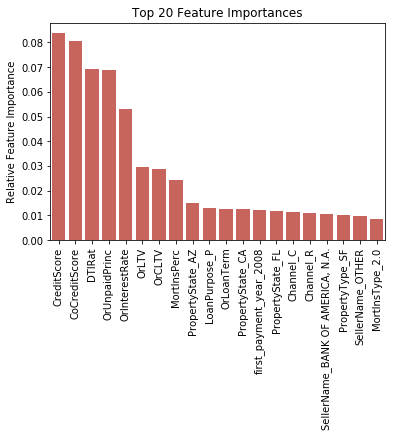

In [21]:
feat_labels = df_new.drop('Default', axis=1).columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

ncomp = 20
sns.barplot(x=feat_labels[indices[:ncomp]], y=importances[indices[:ncomp]], color=sns.xkcd_rgb["pale red"])
plt.title('Top 20 Feature Importances')
plt.ylabel('Relative Feature Importance')
plt.xticks(rotation=90)

## booster
gradual learning
* iterating learning
* dependent estimators
* learning different tasks for the same goal
* sequential building

Possible steps in gradual learning:
1. First attempt (initial model)
2. Feedback (model evaluation)
3. Correct errors (subsequent model)


### Adaptive boosting

Instances are drawn using a sample distribution
* Difcult instances have higher weights
* Initialized to be uniform

Estimators are combined with a weighted
* majority voting
* Good estimators are given higher weights

Guaranteed to improve

Classication and Regression

* base_estimator Default: Decision Tree (max_depth=1)
* n_estimators Default: 50
* learning_rate Default: 1.0
* loss default linear (can be change to square or exponential)
* Trade-off between n_estimators and learning_rate

In [22]:
# Build and fit a tree-based AdaBoost classifier
reg_ada = AdaBoostClassifier(n_estimators=12, random_state=500)
reg_ada.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = reg_ada.predict(X_test)

# Evaluate the performance using the RMSE
print('Adaptive boosting classifier accuracy:  {:}'.format(accuracy_score(y_test, pred)))

Adaptive boosting classifier accuracy:  0.8715183019276587


### Gradient boosting

Objective: $$y=f(X) $$
1. Initial model (weak estimator): $y = f_{1}(X)$
2. New model ts to residuals: $y - f_{1}(X) = f_{2}(X)$
3. New additive model: $y = f_{1}(X) + f_{2}(X)$
4. Repeat n times or until error is small enough
5. Final additive model: $y = f_{1}(X) + f_{2}(X)... + f_{n}(X) = \Sigma_{1}^{n}f_{X}(X)$

**Equivalence to gradient descent**
Residual: $$y-f_{i}(X)$$

Gradient Descent:
$$ loss = \frac{(f_{i}(X)-y)^2}{2}$$

$$gradient = \frac{\partial loss}{\partial f_i} = f_{i}(X)-y$$

Residuals = Negative Gradient:
$$y-f_{i}(X) = - \frac{\partial loss}{\partial f_i(X)}$$


* n_estimators Default: 100
* learning_rate Default: 0.1
* max_depth Default: 3
* min_samples_split
* min_samples_leaf
* max_features

In [23]:
# Build and fit a Gradient Boosting classifier
clf_gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=500)
clf_gbm.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = clf_gbm.predict(X_test)

# Evaluate the performance based on the accuracy
acc = accuracy_score(y_test, pred)
print('Accuracy: {:}'.format(acc))

Accuracy: 0.8755035737491877


### Variations of gradient boosting
* Extreme Gradient Boosting: XGBoost
* Light Gradient Boosting Machine: LightGBM
* Categorical Boosting: CatBoost


### Extreme Gradient Boosting
* Optimized for distributed computing
* Paralleltraining by nature
* Scalable, portable, and accurate

### Light Gradient Boosting Machine
* Released by Microsoft (2017)
* Faster training and more efcient
* Lighter in terms of space
* Optimized for parallel and GPU processing
* Useful for problems with big datasets and constraints of speed or memory

### Categorical Boosting
* Open sourced by Yandex (April 2017)
* Built-in handling of categorical features
* Accurate and robust
* Fast and scalable
* User-friendly API


## XGBClassifier

In [24]:
model=xgb.XGBClassifier(max_depth=2, objective="reg:logistic")
model.fit(X_train, y_train)
pred=model.predict(X_test)

# Evaluate the performance based on the accuracy
acc = accuracy_score(y_test, pred)
print('Accuracy: {:}'.format(acc))

Accuracy: 0.8738141650422352


## stacking
* alike relay race

Very similar to the voting and averaging methods where the whole dataset is used by each model to make prediction, except instead of simply voting or averaging as the combiner to get the final prediction, stacking has a second layer of model which has all the predictions as the input features in addition to the original data. 

## mlxtend 

In [25]:
# Create the first-layer models
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
clf_dt = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=15, random_state=500)
clf_nb = GaussianNB()

# Create the second-layer model (meta-model)
clf_lr = LogisticRegression()

# Create and fit the stacked model
clf_stack = StackingClassifier(classifiers=[clf_knn, clf_dt, clf_nb], meta_classifier=clf_lr)
clf_stack.fit(X_train, y_train)

# Evaluate the stacked model’s performance
print("Accuracy: {:}".format(accuracy_score(y_test, clf_stack.predict(X_test))))

Accuracy: 0.8350010829542993


## cross validation with Gradient Boosting

In [28]:
clf_gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=500)

# Perform cross-validation
cross_val_scores = cross_val_score(clf_gbm, X_train, y_train, scoring="accuracy", cv=3)

# Print avg. accuracy
print("3-fold accuracy:", np.mean(cross_val_scores))

3-fold accuracy: 0.874637210309725


## cross validation and parameter tuning with Gradient Boosting

In [29]:
clf_gbm = GradientBoostingClassifier(random_state=500)

# Create the parameter grid
gbm_param_grid = {
    'clf_gbm__learning_rate': np.arange(0.05, 1, 0.05),
    'clf_gbm__n_estimators': np.arange(50, 200, 50)
}

In [ ]:
# Perform RandomizedSearchCV
randomized_acc = RandomizedSearchCV(estimator=clf_gbm,param_distributions=gbm_param_grid, n_iter=2, scoring="accuracy", cv=2,verbose=1)

# Fit the estimator
randomized_acc.fit(X_train,y_train)

# Compute metrics
print(randomized_acc.best_score_)
print(randomized_acc.best_estimator_)

In [ ]:
pred = randomized_acc.predict(X_test)
# Evaluate the performance based on the accuracy
acc = accuracy_score(y_test, pred)
print('Accuracy: {:}'.format(acc))

In [ ]:
estimator.get_params().keys()